# Deconvolution of the Energy plane signals

In [9]:
%matplotlib inline

In [4]:
from IPython.display import Image

## PMT connection mode



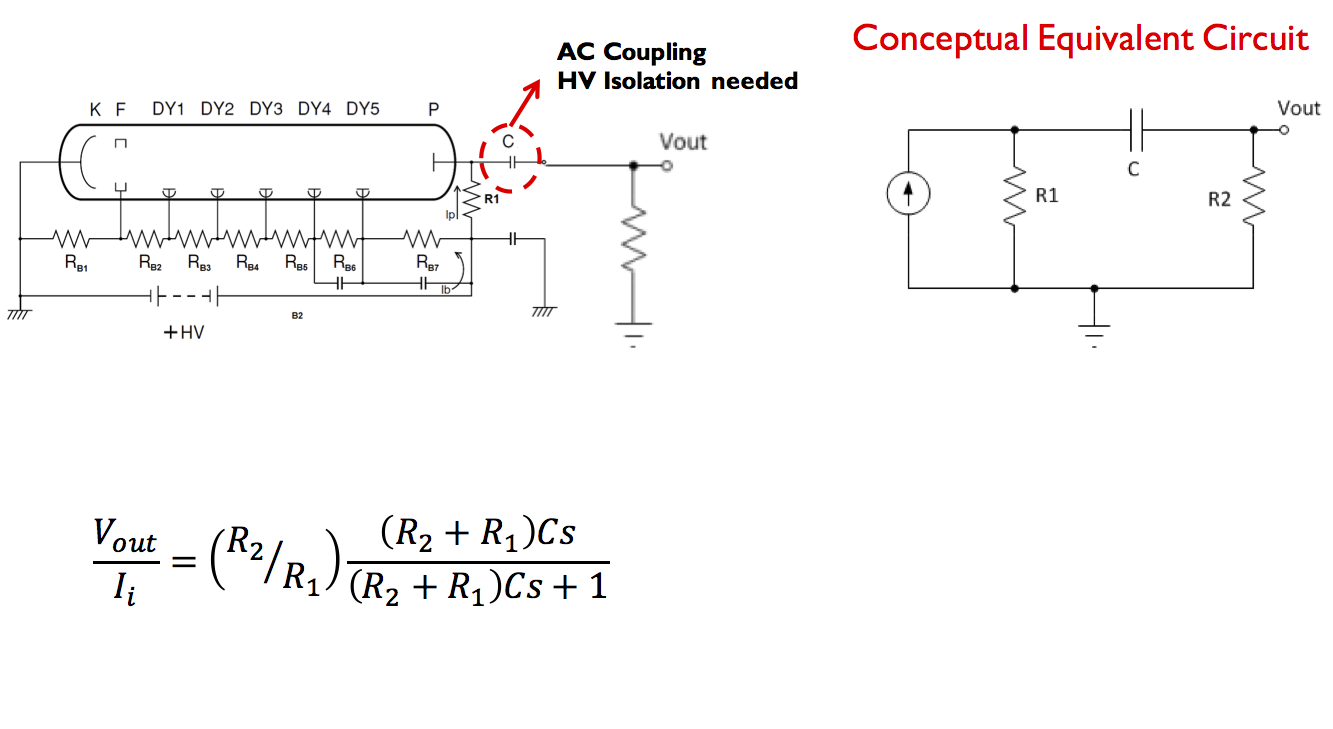

In [5]:
Image(filename='images/fee.png')

## CR diferentiator 

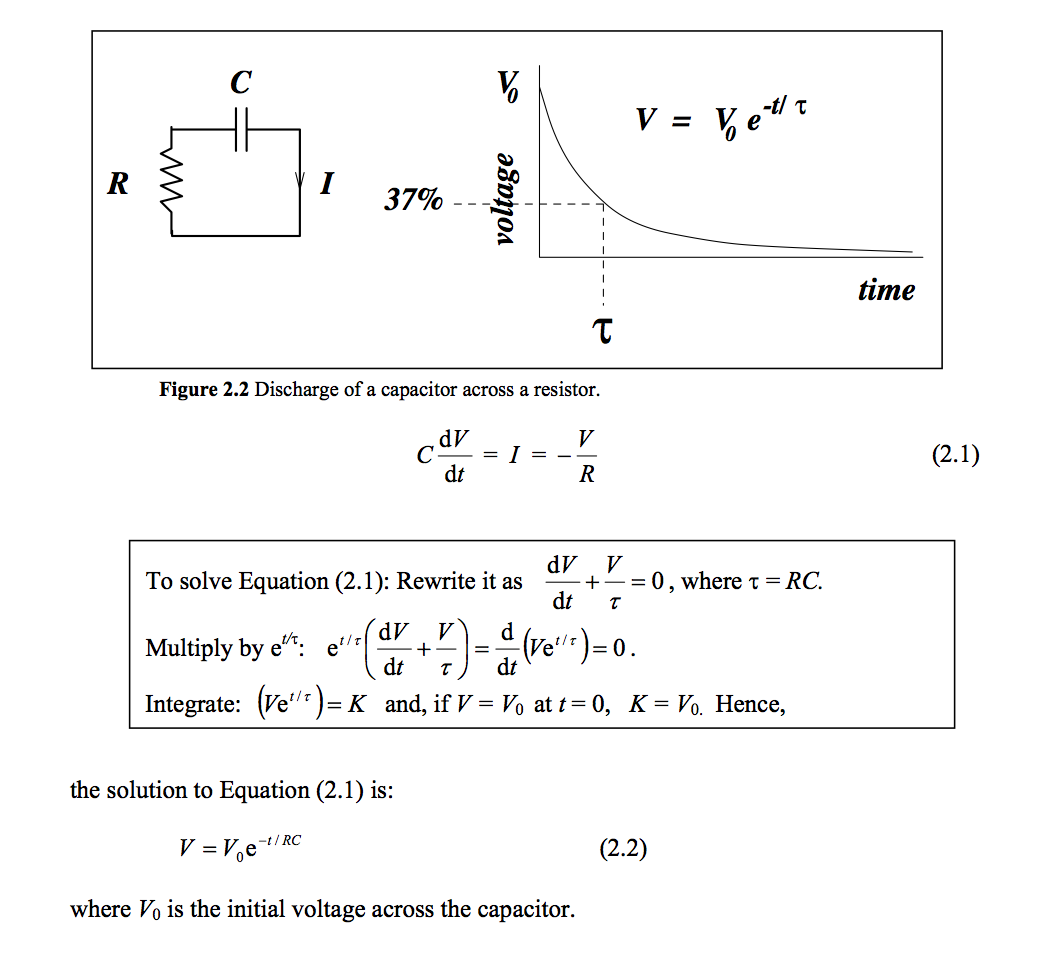

In [6]:
Image(filename='Images/RC-circuit.png') 

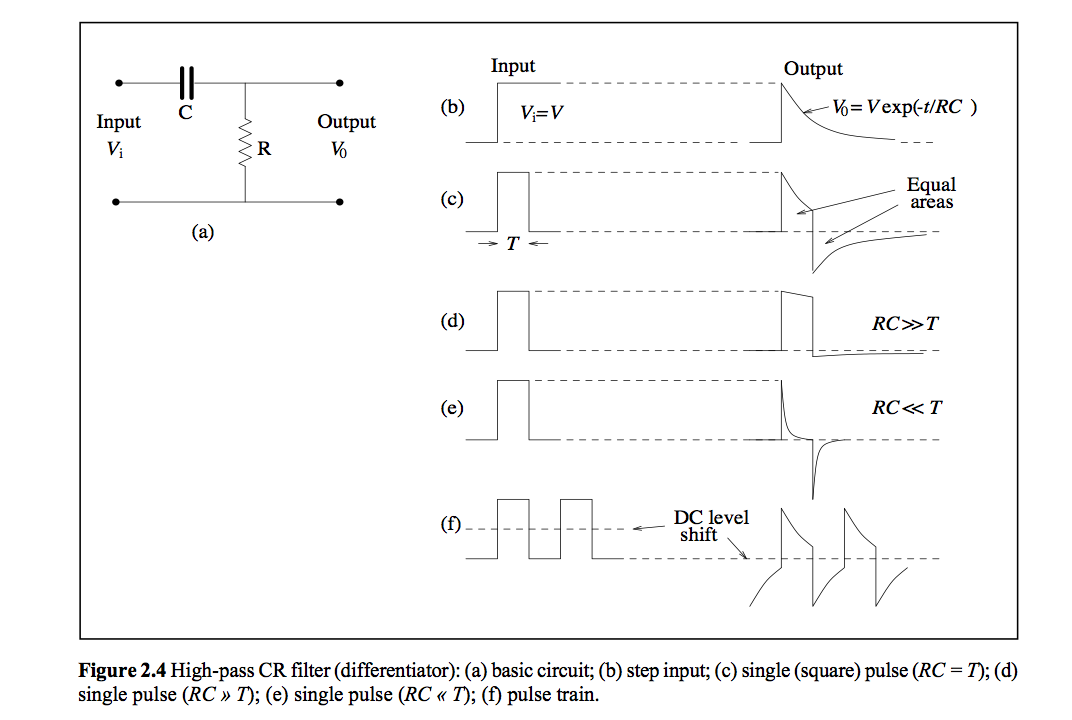

In [7]:
Image(filename='Images/CR-differentiator.png')  

## A CR differentiator is a High Pass Filter (HPF)


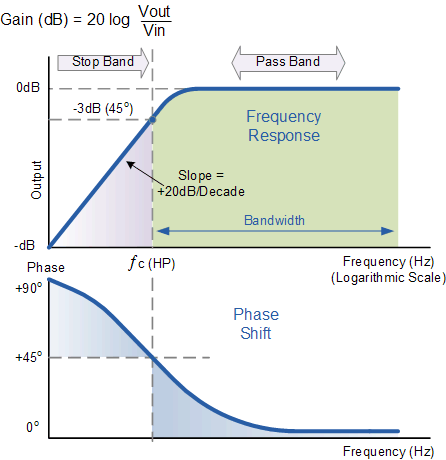

In [20]:
Image(filename='Images/fil13.png')  

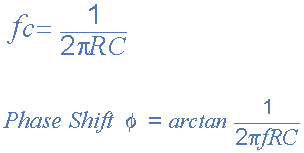

In [22]:
Image(filename='Images/fil37.png')  

A HPF of this type is the simplest case of the most general Butterworth filter. The LPF implemented by the FEE can also be described in terms of a BWF. The Scipy library includes utilities to define HPF and LPF BF.

In [23]:
from Filter import *

In [24]:
import FEParam as FP
from Util import *
from scipy import signal
import SPE as SP

 

###########################################################

def FilterCutoffFrequency(R=4700, C=8e-9):
	"""
	Takes R (in Ohms) and C (in Farad) and returns frequency in Htz
	"""
	
	return 1./(2*pi*R*C)

class Filter:

 	def __init__(self,type='high',fc=5E3,fs= 1e+9):
		"""
		Defines a Butterworth HPF (high pass frequency) or LPF (low pass frequencey) filter 
		the default sampling frequencey is 1 GHz (inverse of 1 ns time)
		type may be equal to hig or low
		"""
		self.fc = fc
		self.fs = fs
		self.W = 2*self.fc/self.fs
		self.type = type
		self.b, self.a = signal.butter(1, self.W, btype=self.type, analog=False, output='ba')
		self.ba, self.aa = signal.butter(1, 2*self.fc, btype=self.type, analog=True, output='ba')

	def FilterCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.b,self.a

  	def FilterAnalogCoef(self):
		"""
		Returns the filter coefficients
		"""
  		return self.ba,self.aa

	def FilterPulse(self,pulse):
		"""
		Filters a pulse
		"""
  		return signal.lfilter(self.b,self.a, pulse)

  	def FilterResponse(self):
  		"""
  		Gives the response of the filter y frequency-amplitude
  		"""

  		self.w, self.h = signal.freqs(self.ba, self.aa)
  		return self.w, self.h


	def __str__(self):
        
		s= """
		Filter:
		fc = %7.2f Hz, fs = %7.2f, W = %7.2f Hz type = %s  
		"""%(self.fc, self.fs, self.W, self.type)
		return s

	

## The effect of filters in signals

In [25]:
def FilterScan(spe,C):
  	spe_pulse_t, spe_pulse = spe.SpePulse(100*ns)
	print "Capacitance of filter (nF) = %7.2f"%(C/nF)

	Ra = np.logspace(0., 3.0, num=3)
    
  	for R in Ra:
  		print "Resistance of filter (O) = %7.2f"%(R)

  		freq_HPF = FilterCutoffFrequency(R=R*ohm, C=C)
  		print "cutoff frequence (kHz) = %7.2f"%(freq_HPF/1e+3)
  		hpf = Filter(type='high',fc=freq_HPF,fs=f_sample)
  		w,h = hpf.FilterResponse()
  		plt.subplot(3,1,1)
		plt.xscale('log')
		plt.title('HPF  frequency response')
		SetPlotLabels(xlabel='Frequency [radians / second]', ylabel='Amplitude [dB]')

		plt.margins(0, 0.1)
		plt.axvline(freq_HPF, color='green') # cutoff frequency
		plt.plot(w, 20 * np.log10(abs(h)))

		spe_hp_pulse = hpf.FilterPulse(spe_pulse)

		ax1 = plt.subplot(3,1,2)
		ax1.set_xlim([0, 200])
		SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  		plt.title('SPE pulse')
		plt.plot(spe_pulse_t/ns, spe_pulse/microampere)

		ax2 = plt.subplot(3,1,3)
		ax2.set_xlim([0, 200])
		SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  		plt.title('SPE pulse after HPF')
		plt.plot(spe_pulse_t, spe_hp_pulse/microampere)

		plt.show()


In [30]:
def FilterCharacterization(spe):
	spe_pulse_t, spe_pulse = spe.SpePulse(100*ns)

  	hpf = Filter(type='high',fc=FP.freq_HPF,fs=FP.f_sample)
  	lpf = Filter(type='low',fc=FP.freq_LPF,fs=FP.f_sample)

  	w,h = hpf.FilterResponse()

  	plt.subplot(2,1,1)
	plt.xscale('log')
	plt.title('HPF  frequency response')
	SetPlotLabels(xlabel='Frequency [radians / second]', ylabel='Amplitude [dB]')

	plt.margins(0, 0.1)
	plt.axvline(FP.freq_HPF, color='green') # cutoff frequency
	plt.plot(w, 20 * np.log10(abs(h)))

	
	w,h = lpf.FilterResponse()
	plt.subplot(2,1,2)

  	
	plt.xscale('log')
	plt.title('LPF  frequency response')
	SetPlotLabels(xlabel='Frequency [radians / second]', ylabel='Amplitude [dB]')

	plt.margins(0, 0.1)
	plt.axvline(FP.freq_LPF, color='green') # cutoff frequency
	plt.plot(w, 20 * np.log10(abs(h)))

	plt.show()

  	spe_hp_pulse = hpf.FilterPulse(spe_pulse)
  	spe_hp_lp_pulse = lpf.FilterPulse(spe_hp_pulse)

  	ax1 = plt.subplot(3,1,1)
	ax1.set_xlim([0, 200])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse')
	plt.plot(spe_pulse_t/ns, spe_pulse/microampere)

	ax2 = plt.subplot(3,1,2)
	ax2.set_xlim([0, 200])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse after HPF')
	plt.plot(spe_pulse_t, spe_hp_pulse/microampere)

	ax3 = plt.subplot(3,1,3)
	ax3.set_xlim([0, 200])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse after HPF + LPF')
	plt.plot(spe_pulse_t, spe_hp_lp_pulse/microampere)

	plt.show()



### Effect in a SPE

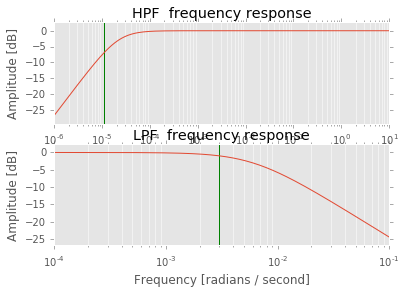

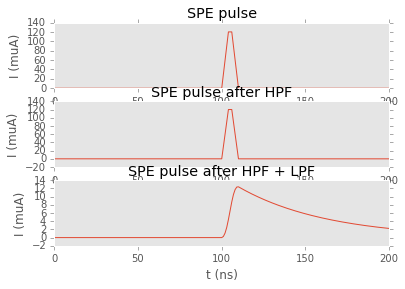

In [61]:
spe = SP.SPE(pmt_gain=FP.PMT_GAIN,x_slope = 5*ns,x_flat = 1*ns)
FilterCharacterization(spe)

In [39]:
def FilterTrain(spe,ti=100*ns,tf=200*ns, tm=50*ns):
	spe_pulse_t, spe_pulse = spe.SpePulseTrain(ti,tf)

	print "pulse train: ti = %7.2f ns, tf = %7.2f ns, area = %7.2g muA"%(ti,tf,spe_pulse.sum())
	
  	hpf = Filter(type='high',fc=FP.freq_HPF,fs=FP.f_sample)
  	lpf = Filter(type='low',fc=FP.freq_LPF,fs=FP.f_sample)

  	w,h = hpf.FilterResponse()

  	plt.subplot(2,1,1)
	plt.xscale('log')
	plt.title('HPF  frequency response')
	SetPlotLabels(xlabel='Frequency [radians / second]', ylabel='Amplitude [dB]')

	plt.margins(0, 0.1)
	plt.axvline(FP.freq_HPF, color='green') # cutoff frequency
	plt.plot(w, 20 * np.log10(abs(h)))

	
	w,h = lpf.FilterResponse()
	plt.subplot(2,1,2)

  	
	plt.xscale('log')
	plt.title('LPF  frequency response')
	SetPlotLabels(xlabel='Frequency [radians / second]', ylabel='Amplitude [dB]')

	plt.margins(0, 0.1)
	plt.axvline(FP.freq_LPF, color='green') # cutoff frequency
	plt.plot(w, 20 * np.log10(abs(h)))

	plt.show()

  	spe_hp_pulse = hpf.FilterPulse(spe_pulse)
  	spe_hp_lp_pulse = lpf.FilterPulse(spe_hp_pulse)
  	area_hp = np.sum(spe_hp_pulse[np.where(spe_hp_pulse>0)])
  	area_hp_lp = np.sum(spe_hp_lp_pulse[np.where(spe_hp_lp_pulse>0)])


  	print "pulse area after HPF = %7.2g muA, pulse area after HPF + LPF  = %7.2g muA"%(
  		area_hp,area_hp_lp)

  	ax1 = plt.subplot(3,1,1)
	ax1.set_xlim([0, tf+tm])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse')
	plt.plot(spe_pulse_t/ns, spe_pulse/microampere)

	ax2 = plt.subplot(3,1,2)
	ax2.set_xlim([0, tf+tm])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse after HPF')
	plt.plot(spe_pulse_t, spe_hp_pulse/microampere)

	ax3 = plt.subplot(3,1,3)
	ax3.set_xlim([0, tf+tm])
	SetPlotLabels(xlabel='t (ns)', ylabel='I (muA)')
  	plt.title('SPE pulse after HPF + LPF')
	plt.plot(spe_pulse_t, spe_hp_lp_pulse/microampere)

	plt.show()




### Effect in square pulses of different lengths

#### Short

pulse train: ti =  100.00 ns, tf =  200.00 ns, area = 4.5e+08 muA


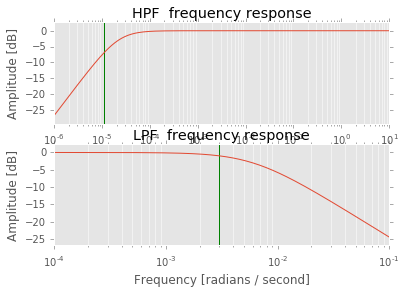

pulse area after HPF = 4.5e+08 muA, pulse area after HPF + LPF  = 4.5e+08 muA


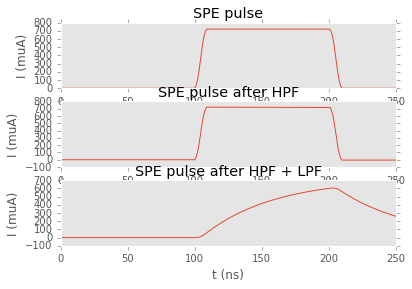

In [40]:
FilterTrain(spe,ti=100*ns,tf=200*ns, tm=50*ns)

####  Medium

pulse train: ti =  100.00 ns, tf = 2000.00 ns, area = 8.6e+09 muA


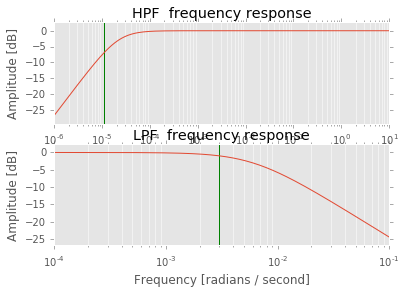

pulse area after HPF =   8e+09 muA, pulse area after HPF + LPF  =   8e+09 muA


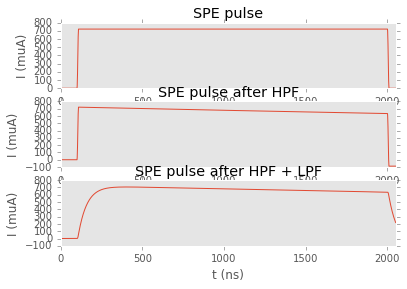

In [41]:
FilterTrain(spe,ti=100*ns,tf=2000*ns)

#### Long

pulse train: ti =  100.00 ns, tf = 20000.00 ns, area =   9e+10 muA


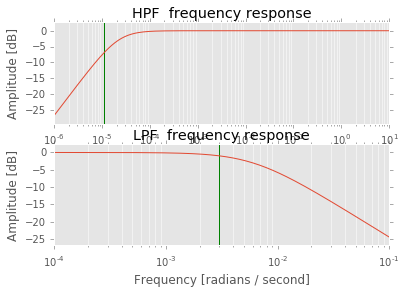

pulse area after HPF = 4.9e+10 muA, pulse area after HPF + LPF  = 4.9e+10 muA


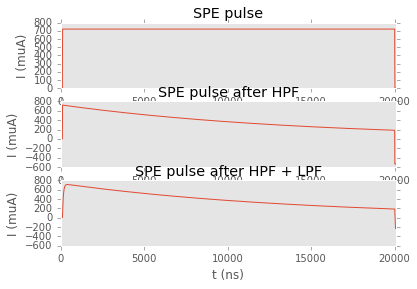

In [42]:
FilterTrain(spe,ti=100*ns,tf=20000*ns)

## First step for deconvolution: simulate the signal

### PMT response

1. To simulate the response of the PMTs, one needs to start with an input signal, which can be, for example a square pulse (used for calibration), or a simulation of the physical signal that the PMT receives. In any case the "waveform" describing the input pulse must be densely binned to simulate a continous signal. Given that the DAQ will sample each 25 ns, a reasonable bin for the input waveform is 1 ns.

2. The input waveform is then described as a continous (1 ns) train of photoelectrons. The PMT response to each photoelectron is simulated following the experimental input as a trapezoidal pulse. 

### FEE response

1. The output of the PMT is then passed by a HPF defined by the RC constant and an additional LPF filter used for shaping. The resulting signal shows the diferentiation introduced by the filter.

2. Finally the signal is decimated by the DAQ producing waveforms (in bins of 25 ns and in adc counts). 

4. It follows that for MC data, the initial waveforms of the PMTs (in photoelectrons per 1 ns bin, called MCRD) is transformed in a signal (adc counts per 25 ns bins) which reflects the effect of the PMT and electronics (RWF).

## Simulation of EneRgy PlanE (SIERPE)

In [10]:
from SPE import *
from FEE2 import *

## Example: simulate a square pulse

In [11]:
def pulse_train(signal_start=2000*ns, signal_length=5000*ns, daq_window = 20*microsecond, noise=FP.NOISE_FEE_rms):
    signal_end = signal_start + signal_length
    spe = SP.SPE()
    fee = FEE()
    # PMT response to a photon train 
    signal_t, signal_PE = spe.SpePulseTrain(signal_start,signal_end,daq_window)
    # spe in voltage (without FEE)
    signal_PE_v = fee.VSignal(signal_PE)
    #effect of FEE
    signal_fee = fee.FEESignal(signal_PE, noise_rms=noise)
    #effect of DAQ
    signal_t_daq, signal_daq = fee.DAQSignal(signal_t, signal_fee, noise_rms=0)
    signal_daq *=FP.time_DAQ #re-scale by decimation factor
    plt.figure(figsize=(12,12))
    
    ax1 = plt.subplot(2,2,1)
    ax1.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe train (muA)')
    plt.plot(signal_t, signal_PE/muA)

    ax2 = plt.subplot(2,2,2)
    ax2.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe train (mV)')
    plt.plot(signal_t, signal_PE_v/mV)
   
    ax3 = plt.subplot(2,2,3)
    ax3.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE (mV)')
    plt.plot(signal_t, signal_fee/mV)
    
    ax4 = plt.subplot(2,2,4)
    ax4.set_xlim([0, len(signal_t)])
    SetPlotLabels(xlabel='t (ns)', ylabel='spe+FEE+DAQ (adc)')
    plt.plot(signal_t_daq, signal_daq)
    
    area = np.sum(signal_daq)
    print("adc counts per spe = {}".format(area))
    
    plt.show()
    return signal_t, signal_fee




adc counts per spe = 877672.482144


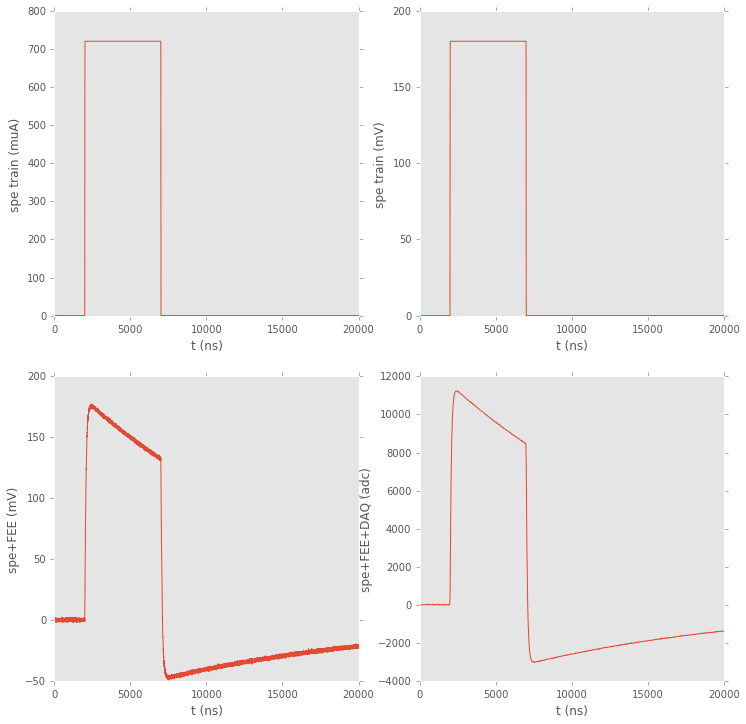

In [12]:
signal_t, signal_fee = pulse_train()

## Second step:  perform DBLR

1. DBLR profits from the fact that the inverse of the HPF is a constant!

In [15]:
fee = FEE()
print fee



		NEW FEE
  		PMT gain = 4.5e+06
  		decoupling capacitor =    6.75 nF
  		decoupling resistor = 2350.00 ohm
  		resitor gain =  250.00 ohm
  		HPF frequency =   1e+04 Hz  W_HPF =   2e-05 
  		LPF frequency =   2e+06 Hz  W_LPF =   0.004
  		LPF frequency noise =   2e+05 Hz  
  


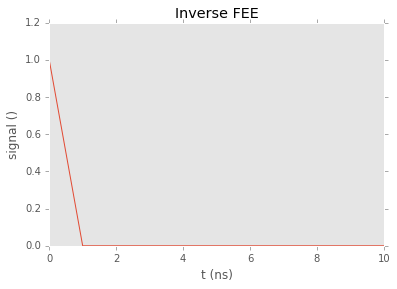

In [16]:
signal_fee_inv = fee.InverseSignal(signal_t)
plot_signal(signal_t/ns,signal_fee_inv,
                title = 'Inverse FEE', 
                signal_start=0*ns, signal_end=10*ns, 
                units='')

In [17]:
def DeconvSimple(signal,signal_inv):
	"""
	Deconvolution of the fine-grained fee signal (no DAQ)
	no noise
	using true start and end of signals
	"""

	coef = signal_inv[100]
	
	print "coef = %7.4g"%coef

	acum = np.zeros(len(signal))

	acum[0]=coef*signal[0]
	for n in xrange(1,len(signal)):
		acum[n] = acum[n-1] + signal[n]

	signal_r = signal + coef*acum

	return signal_r

In [18]:
signal_r = DeconvSimple(signal_fee,signal_fee_inv)

coef = 6.304e-05


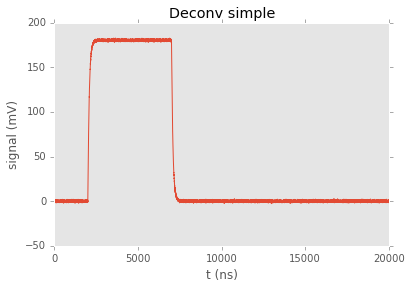

In [19]:
plot_signal(signal_t/ns,signal_r/mV,
                	title = 'Deconv simple', 
                	signal_start=0, signal_end=len(signal_t), 
                	units='mV')

## Deconvolution of physical signals

1. NEW/NEXT physical signals vary in length from few mus to some 100 mus. The effect of the HPF is different for each type of signal, but the deconvolution procedure is the same. 

2. As an example we can examine Kripton signals

In [43]:
ls '/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5'

/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5


In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import tables 
import numpy as np

In [46]:
h5f =tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5', "r+") 

In [47]:
h5f

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/data/Waveforms/25ns/WF_Na_test_RWF.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=9, complib='blosc', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/BLR (Group) ''
/BLR/acum (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 8192)
/BLR/mau (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 8192)
/BLR/pulse_on (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/BLR/wait_over (EArray(10, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 16384)
/De

### True Waveform 

In [55]:
pmttwf = h5f.root.RD.pmttwf
pmt0 = pmttwf[0,0]

In [49]:
pmttwf

/RD/pmttwf (EArray(10, 12, 24000), shuffle, blosc(9)) ''
  atom := Int32Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 24000)

In [50]:
def plts(signal, signal_start=0, signal_end=1e+4, offset=5):

    ax1 = plt.subplot(1,1,1)
    ymin =np.amin(signal[signal_start:signal_end]) - offset
    ymax =np.amax(signal[signal_start:signal_end]) + offset
    ax1.set_xlim([signal_start, signal_end])
    ax1.set_ylim([ymin, ymax])
    plt.plot(signal)

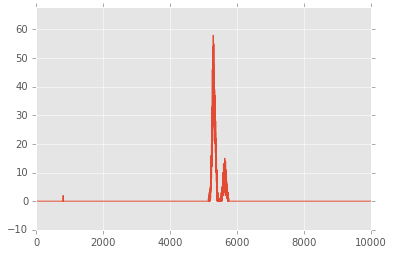

In [52]:
plts(pmt0,0,10000,5)

### Raw Waveform

In [56]:
pmtrwf = h5f.root.RD.pmtrwf
pmtr0 = pmtrwf[0,0]

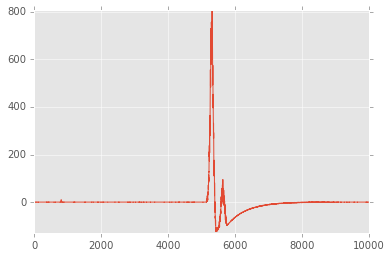

In [57]:
plts(pmtr0,0,10000,5)

## DBLR algorithm

1. The DBLR algorithm for NEW/NEXT (credits: Super-Raul, Super-Vicente, JJ's old student) is quite sophisticated. The core of the algorithm is the simple accumulator described above, but considerable gimnastics is implemented to make sure that the signal is properly recovered. 

2. The algorithm was initally written in MATLAB, then translated to python. 

In [ ]:
def BLR(signal_daq, coef, mau_len=250, thr1 = 3*FP.NOISE_ADC, thr2 = 0, 
        thr3 = FP.NOISE_ADC, log='INFO'):

    """
    Deconvolution offline of the DAQ signal using a MAU
    moving window-average filter of a vector data. See notebook 
    y(n) = (1/WindowSize)(x(n) + x(n-1) + ... + x(n-windowSize))
    in a filter operation filter(b,a,x):
    b = (1/WindowSize)*ones(WindowSize) = (1/WS)*[1,1,1,...]: numerator
    a = 1 : denominator
    y = filter(b,a,x)
    y[0] = b[0]*x[0] = (1/WS) * x[0]
    y[1] = (1/WS) * (x[0] + x[1])
    y[WS-1] = mean(x[0:WS])
    y[WS] = mean(x[1:WS+1])
    and so on
    """
    
    lg = 'logging.'+log
    logger.setLevel(eval(lg))
    len_signal_daq = len(signal_daq)
    sblr = SBLR(len_signal_daq)

    signal_i = np.copy(signal_daq) #uses to update MAU while procesing signal
    nm = mau_len
    B_MAU = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch 
#    allows to compute the baseline of the signal  
    
    sblr.MAU[0:nm] = SGN.lfilter(B_MAU,1, signal_daq[0:nm])
    sblr.acum[nm] =  sblr.MAU[nm]
    sblr.BASELINE = sblr.MAU[nm-1]

    logging.debug("""-->BLR: 
                     MAU_LEN={}
                     thr1 = {}, thr2 = {}, thr3 = {} =""".format(
                     mau_len, thr1, thr2, thr3))
    logging.debug("n = {}, acum[n] = {} BASELINE ={}".format(nm, sblr.acum[nm],sblr.BASELINE))

#----------

# While MAU inits BLR is switched off, thus signal_r = signal_daq 

    sblr.signal_r[0:nm] = signal_daq[0:nm] 
    pulse_on=0
    wait_over=0
    offset = 0
    
    # MAU has computed the offset using nm samples
    # now loop until the end of DAQ window

    logging.debug("nm = {}".format(nm))
    
    for k in range(nm,len_signal_daq): 

        trigger_line = sblr.MAU[k-1] + thr1
        sblr.pulse_on[k] = pulse_on
        sblr.wait_over[k] = wait_over 
        sblr.offset[k] = offset
        
        # condition: raw signal raises above trigger line and 
        # we are not in the tail
        # (wait_over == 0)
        if signal_daq[k] > trigger_line and wait_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value 
            #of the MAU before pulse starts (at k-1)

            if pulse_on == 0: # pulse just started
                #offset computed as the value of MAU before pulse starts
                offset = sblr.MAU[k-1]  
                pulse_on = 1 
                
            #Pulse is on: Freeze the MAU
            sblr.MAU[k] = sblr.MAU[k-1]  
            signal_i[k] = sblr.MAU[k-1]  #signal_i follows the MAU
            
            #update recovered signal, correcting by offset
            sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
            sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                  
            
        else:  #no signal or raw signal has dropped below threshold
                      
        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if pulse_on == 1: #reconstructed signal still on
                # switch the pulse off only when recovered signal 
                #drops below threshold
                #slide the MAU, still frozen. 
                # keep recovering signal
                
                sblr.MAU[k] = sblr.MAU[k-1] 
                signal_i[k] = sblr.MAU[k-1]
                sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - offset;
                sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k] 
                
                #if the recovered signal drops before trigger line 
                #rec pulse is over!
                if sblr.signal_r[k] < trigger_line + thr2:
                    wait_over = 1  #start tail compensation
                    pulse_on = 0   #recovered pulse is over
                      

            else:  #recovered signal has droped below trigger line
            #need to compensate the tail to avoid drifting due to erros in 
            #baseline calculatoin

                if wait_over == 1: #compensating pulse
                    # recovered signal and raw signal 
                    #must be equal within a threshold
                    # otherwise keep compensating pluse
                        
                    if signal_daq[k-1] < sblr.signal_r[k-1] - thr3:
                        # raw signal still below recovered signal 
                        # keep compensating pulse
                        # is the recovered signal near offset?
                        upper = offset + (thr3 + thr2)
                        lower = offset - (thr3 + thr2)
                        
                        if sblr.signal_r[k-1] > lower and sblr.signal_r[k-1] < upper:
                            # we are near offset, activate MAU. 
                            
                            signal_i[k] = sblr.signal_r[k-1]
                            sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                                      
                        else: 
                            # rec signal not near offset MAU frozen  
                            sblr.MAU[k] = sblr.MAU[k-1]
                            signal_i[k] = sblr.MAU[k-1]
                            
                        # keep adding recovered signal  
                        sblr.acum[k] = sblr.acum[k-1] + signal_daq[k] - sblr.MAU[k]
                        sblr.signal_r[k] = signal_daq[k] + coef*sblr.acum[k]
                        
                    else:  # raw signal above recovered signal: we are done 
                        
                        wait_over = 0
                        sblr.acum[k] = sblr.MAU[k-1]
                        sblr.signal_r[k] = signal_daq[k]
                        signal_i[k] = sblr.signal_r[k]
                        sblr.MAU[k] = np.sum(signal_i[k-nm:k])*1./nm
                        
                            
                else: #signal still not found
                    
                    #update MAU and signals
                    sblr.MAU[k] = np.sum(signal_i[k-nm:k]*1.)/nm   
                    sblr.acum[k] = sblr.MAU[k-1]
                    sblr.signal_r[k] = signal_daq[k]
                    signal_i[k] = sblr.signal_r[k]  
                                                                                                       
    #energy = np.dot(pulse_f,(signal_r-BASELINE)) 
                       
    #return  signal_r-BASELINE, energy
    return  sblr


### Performance of BLR

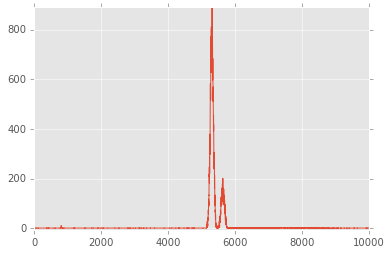

In [60]:
pmtcwf = h5f.root.RD.pmtcwf
pmtc0 = pmtcwf[0,0]
plts(pmtc0,0,10000,5)

## Summary

1. DBLR algorithm performs well, but parameters must be carefully tuned.

2. The effect on the energy resolution appears to be small, but needs to be fully quantified.

3. Conditions 1. and 2. imply that during initial operation of NEW, the deconvolution must be performed offline, not in the FPGA (in fact the FPGA will also perfrom deconvolution of 4 channels for trigger).

4. It also implies that Monte Carlo production must start from MCRD, then the effect of the FEE electronics simulated, then the deconvolution simulated, then the energy of the waveforms measured (with all corrections) and the effect on resolution assesed. This must be done for calibration samples as well as for signal and background samples. 

5. The software to handle the full chaing (from MCRD to CWF) has been developed this summer. Its core is the scipy signal library (to implement the HPF and LPT filters). It is fully written in python.

6. Currently ART does not include neither the simulation of the FEE nor the deconvolution. 


##  How to proceed?

1. For MC

2. For Data


###  For Monte Carlo

1. hdf5 module already operative in art chain (JMB).

2. It allows to write MCRD files using HDF5 and ZLIB compression (250 kB per event to be compared with 10 MB per event in the case of GATE DST).

3. HDF5 MCRD code is the input for the simulation of the FEE plane (SIERPE) which produces Raw Waveforms (RWF), writting a new HDF5 file. The DBLR algorithm then produces Corrected Waveforms (CWF). 

3. A new module (to be written by JMB) can simply read the resulting file containing the CWF and pass them along to the next ART module. 

### For Data

1. Write RWF in hdf5 format (module already avaialble).

2. Pass DBLR algorithm and produce CWF.

3. Read back to art. 

<img align="center" src="images/thanks.jpg" width="400" ></img>